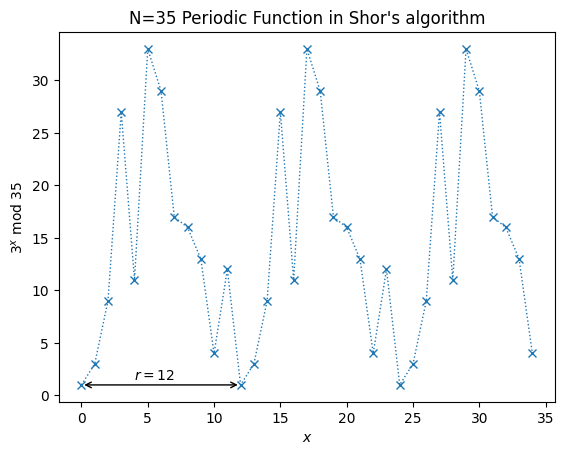

In [44]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, transpile

from qiskit.visualization import *

N = 35
a = 3

xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod {N}', title="N=35 Periodic Function in Shor's algorithm")

try:
    r = yvals[1:].index(1) + 1
except ValueError:
    print("error")
else:
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops={'arrowstyle': '<->'})
    plt.annotate(text=f'$r={r}$', xy=(r/3, 1.5))

In [45]:
def qft_dagger(qreg):
    qc = QuantumCircuit(qreg)

    for j in range(qreg.size // 2):
        qc.swap(qreg[j], qreg[-1-j])
        
    for itarg in range(qreg.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1
            qc.cp(-2.*np.pi*(2**power), ictrl, itarg)
        qc.h(itarg)
    
    qc.name = "QFT^dagger"
    
    return qc

In [46]:
def c_amod15(a, l):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("error a")

    U = QuantumCircuit(4)

    ##############################
    if a in [2, 13]:
        U.swap(3,2)
        U.swap(2,1)
        U.swap(1,0)
    elif a in [4, 11]:
        U.swap(3,1)
        U.swap(2,0)
    elif a in [8, 7]:
        U.swap(1,0)
        U.swap(2,1)
        U.swap(3,2)

    if a in [7, 11, 13]:
        U.x([0,1,2,3])

    ##############################
    U_power = U.repeat(2**l)

    gate = U_power.to_gate()
    gate.name = f"{a}^{2**l} mod 15"

    c_gate = gate.control()
    return c_gate

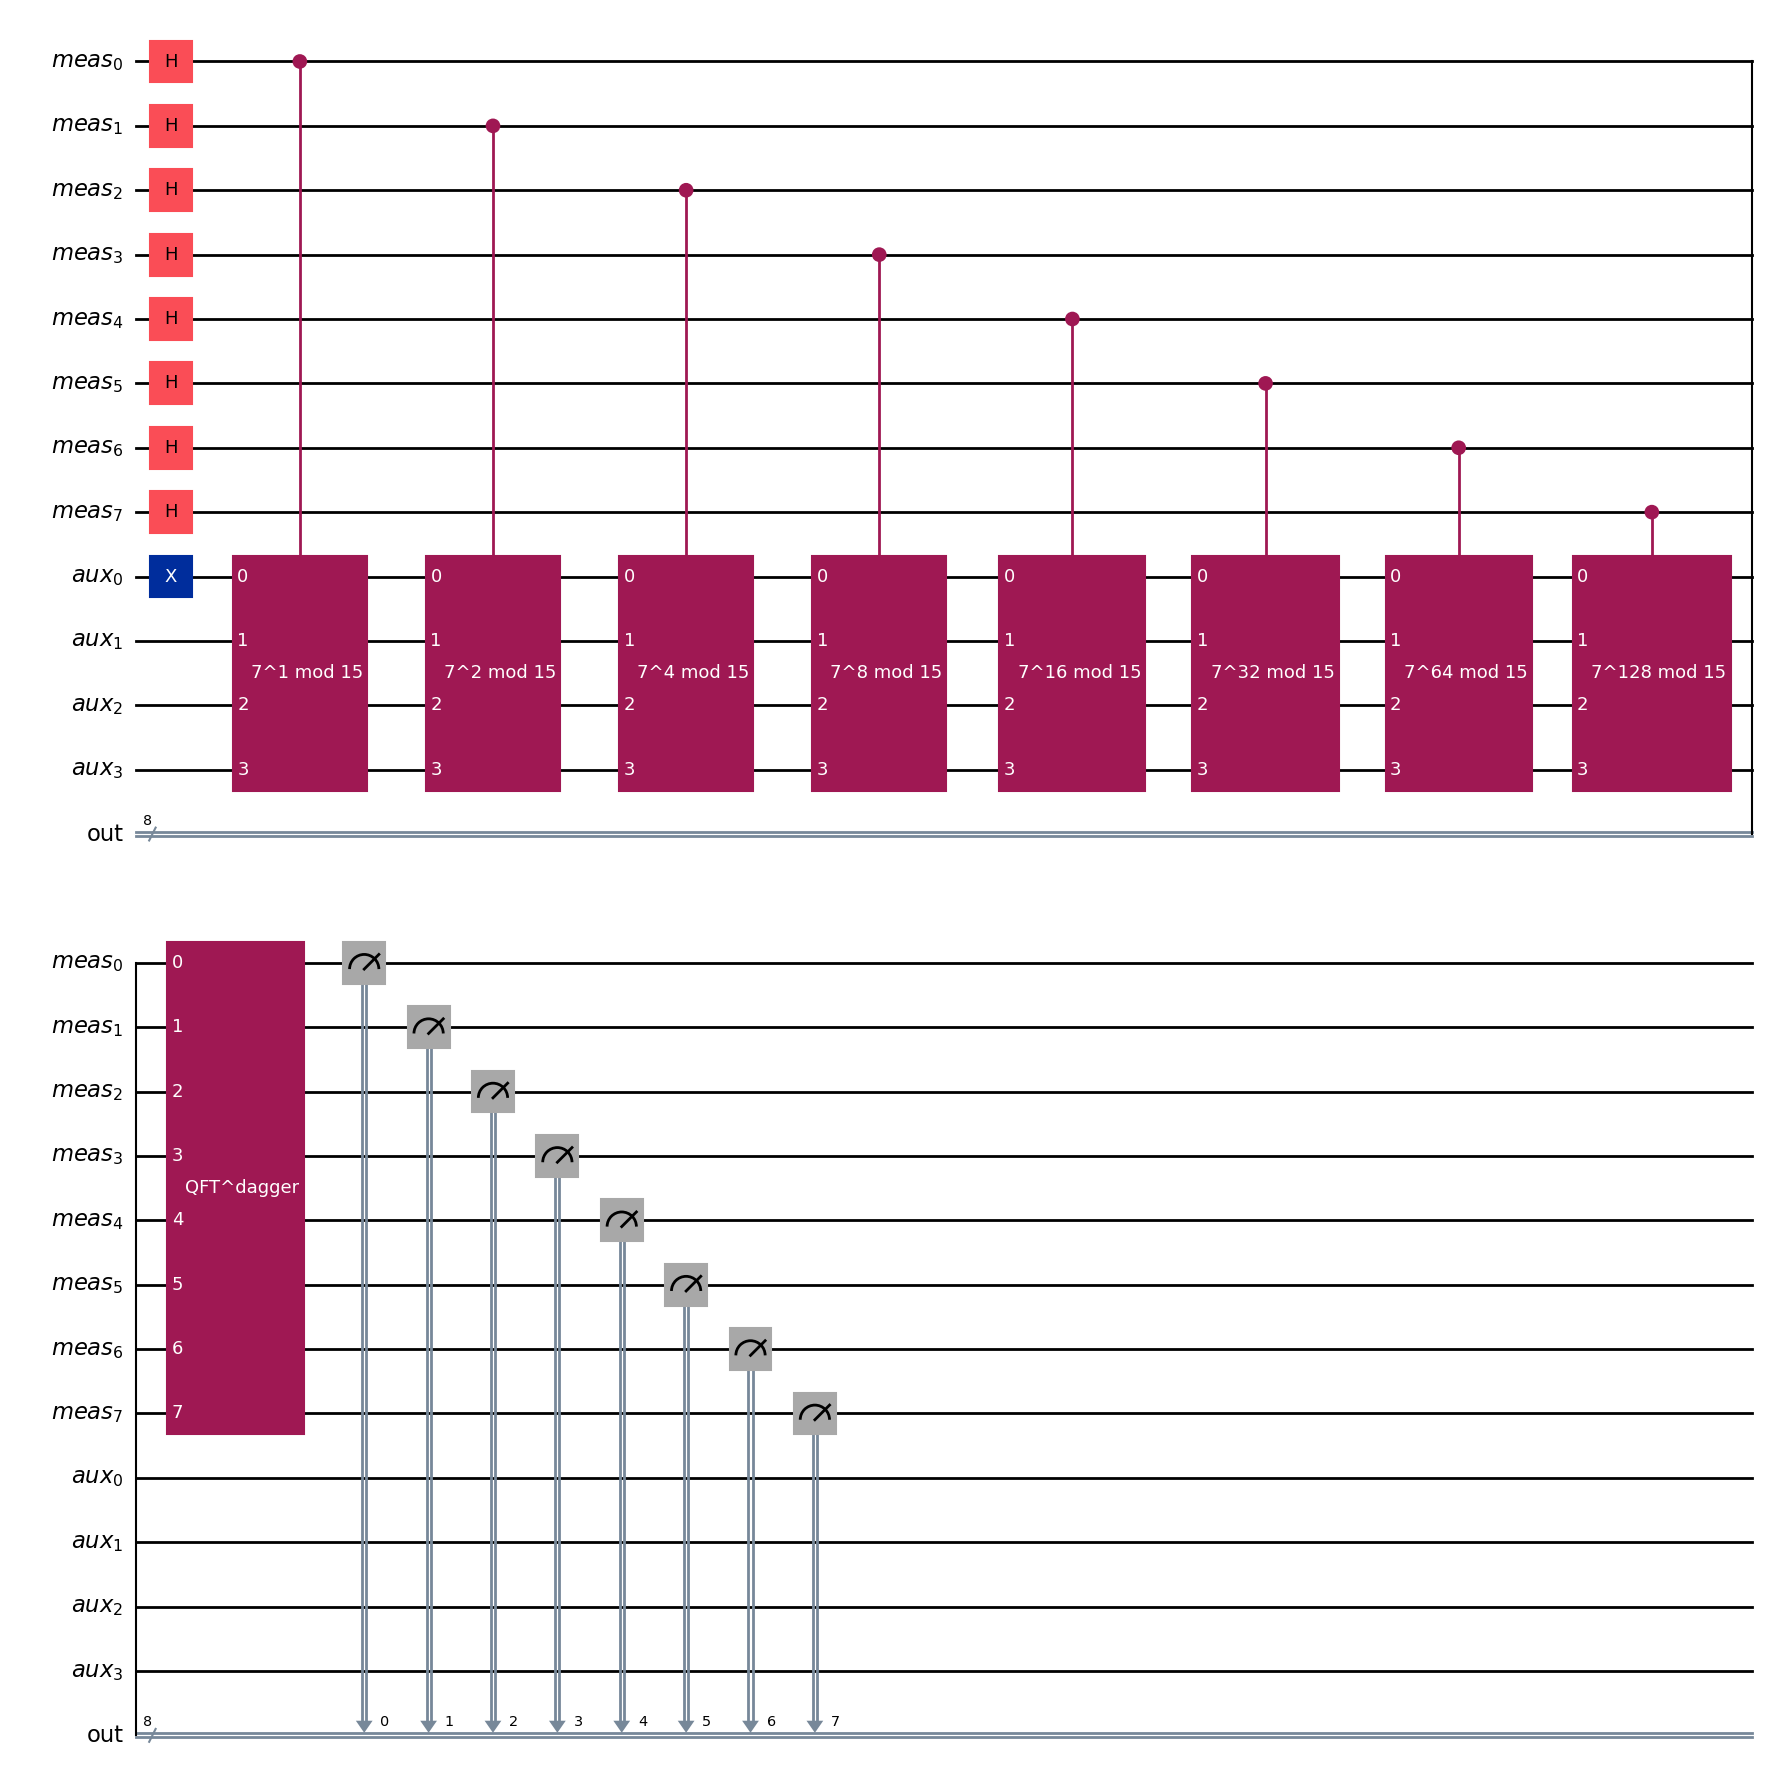

In [52]:
a = 7

n_meas = 8

qreg_meas = QuantumRegister(n_meas, name="meas")
qreg_aux = QuantumRegister(4, name="aux")
creg_meas = ClassicalRegister(n_meas, name="out")

qc = QuantumCircuit(qreg_meas, qreg_aux, creg_meas)

qc.h(qreg_meas)
qc.x(qreg_aux[0])

for l, ctrl in enumerate(qreg_meas):
    qc.append(c_amod15(a,l), qargs=([ctrl]+qreg_aux[:]) )

qc.append(qft_dagger(qreg_meas), qargs=qreg_meas)

qc.measure(qreg_meas, creg_meas)
qc.draw('mpl')

In [49]:
sim = AerSimulator()

compiled_circuit = transpile(qc, sim)

job = sim.run(compiled_circuit, shots=1024) 
result = job.result()

counts = result.get_counts(compiled_circuit)
print(counts)

{'00000000': 251, '01000000': 248, '11000000': 266, '10000000': 259}


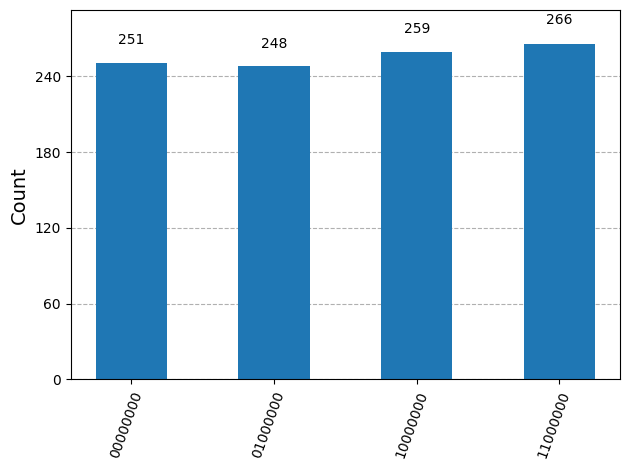

In [50]:
plot_histogram(result.get_counts(compiled_circuit))

In [60]:
rows, measured_phases = [], []

shot = 1024
for output in counts.values():
    phase = output / shot
    measured_phases.append(phase)
    rows.append(f"{output:3d}    {output:3d}/{shot} = {phase:.3f}")

print("Register   Output    Phase")
print("---------------------------------")
for row in rows:
    print(row)

Register   Output    Phase
---------------------------------
251    251/1024 = 0.245
248    248/1024 = 0.242
266    266/1024 = 0.260
259    259/1024 = 0.253


In [63]:
from fractions import Fraction

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(f"{phase:10.3f}     {frac.numerator:2d}/ {frac.denominator:2d}   {frac.denominator:13d}")

print("Phase   Fraction             Guess for r")
print("-----------------------------------------")
for row in rows:
    print(row)    

Phase   Fraction             Guess for r
-----------------------------------------
     0.245      1/  4               4
     0.242      1/  4               4
     0.260      4/ 15              15
     0.253      1/  4               4
